In [2]:
import random
import math
import numpy as np

In [3]:
import random

def cluster_ising(S, N, p, vecinos):
    # Step 1: Select a random spin
    j = random.randint(0, N-1)

    # Step 2: Initialize cluster with the selected spin
    C = {j}
    P = {j}

    # Step 3: Expand the cluster
    while P:
        # Pick any element from P
        k = P.pop()

        # For each neighbor of k that is not in the cluster
        for i in vecinos[k]:
            if i not in C and S[i] == S[k]:
                # With probability p, add the spin to the cluster
                if random.uniform(0, 1) < p:
                    P.add(i)
                    C.add(i)

    # Step 4: Flip all spins in the cluster
    for k in C:
        S[k] *= -1

    # Return the updated spin configuration
    return S


In [4]:
# Define the lattice size
L = 6
N = L * L  # Total number of spins

# Create a function to generate periodic boundary neighbors
def generar_vecinos(L):
    vecinos = {}
    for i in range(L):
        for j in range(L):
            k = i * L + j
            vecinos[k] = []

            # Arriba
            vecinos[k].append(((i - 1) % L) * L + j)
            # Abajo
            vecinos[k].append(((i + 1) % L) * L + j)
            # Izquierda
            vecinos[k].append(i * L + (j - 1) % L)
            # Derecha
            vecinos[k].append(i * L + (j + 1) % L)

    return vecinos

# Generate neighbors for the lattice
vecinos = generar_vecinos(L)

# Función para la simulación de Ising con flipping de clusters
def simulate_ising_cluster(L, N, T, iter):
    beta = 1 / T
    p = 1 - np.exp(-2 * beta)  # Probabilidad del cluster
    # Inicialización aleatoria de espines
    S = []
    for k in range(N):
        S.append(random.choice([1, -1]))

    # Energía inicial del sistema
    E = 0
    for k in range(N):
        suma_vecinos = 0
        for j in vecinos[k]:
            suma_vecinos += S[j]
        E += S[k] * suma_vecinos
    E *= -0.5

    # Promedios para energía y magnetización
    E1, E2, M_tot = 0, 0, 0

    # Proceso de iteraciones Markov
    for _ in range(iter):
        # Usar cluster flipping en lugar del algoritmo de Metropolis
        S = cluster_ising(S, N, p, vecinos)

        # Energía total después del flip
        E_new = 0
        for k in range(N):
            suma_vecinos = 0
            for j in vecinos[k]:
                suma_vecinos += S[j]
            E_new += S[k] * suma_vecinos
        E_new *= -0.5

        M_tot += abs(np.sum(S))  # Magnetización total (abs es opcional según def)
        E1 += E_new
        E2 += E_new**2

    M_av = M_tot / (iter * N)
    E_av = E1 / iter
    E2_av = E2 / iter

    return E_av, E2_av, M_av

# Función para el cálculo del calor específico
def calor_especifico(E_av, E2_av, beta, N):
    return beta ** 2 * (E2_av - E_av ** 2) / N  # Definición de c_v

# Simulación para diferentes temperaturas
T_rango = np.linspace(0.5, 4.0, 8)  # Lista de temperaturas
energias = []
cv_s = []

# Número de iteraciones
iter = 10000

# Simulación para cada temperatura
for T in T_rango:
    E_av, E2_av, M_av = simulate_ising_cluster(L, N, T, iter)
    energias.append(E_av / N)  # Energía promedio por espín
    cv_s.append(calor_especifico(E_av, E2_av, 1.0 / T, N))
    print(f'Temperatura: {T}, Energía promedio: {E_av / N}, Calor específico: {calor_especifico(E_av, E2_av, 1/T, N)}')



Temperatura: 0.5, Energía promedio: -1.9999777777777779, Calor específico: 0.0007110399999671952
Temperatura: 1.0, Energía promedio: -1.9972111111111113, Calor específico: 0.03443110666664021
Temperatura: 1.5, Energía promedio: -1.9506, Calor específico: 0.20233695604939486
Temperatura: 2.0, Energía promedio: -1.7508444444444444, Calor específico: 0.6911602488888902
Temperatura: 2.5, Energía promedio: -1.2911333333333335, Calor específico: 0.9869192504888878
Temperatura: 3.0, Energía promedio: -0.8948, Calor específico: 0.5539738153086421
Temperatura: 3.5, Energía promedio: -0.6641888888888888, Calor específico: 0.3065397808616781
Temperatura: 4.0, Energía promedio: -0.5564666666666667, Calor específico: 0.1830203544444443


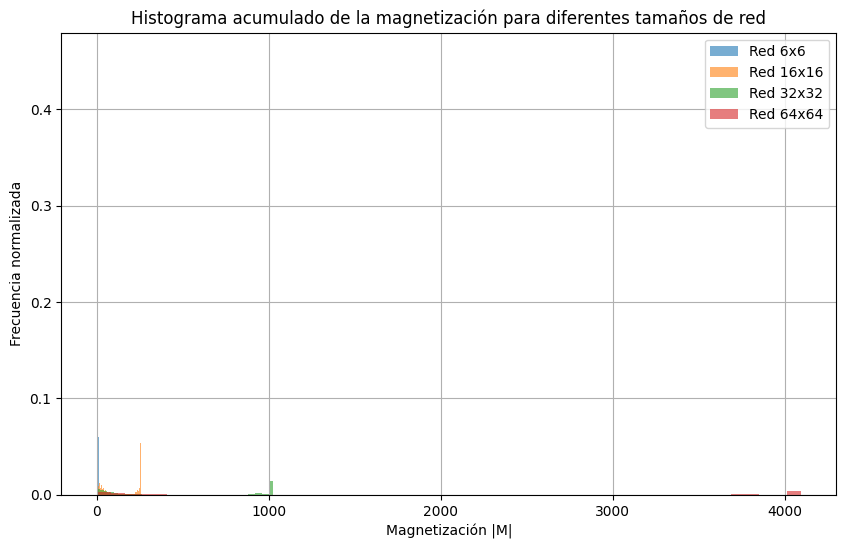

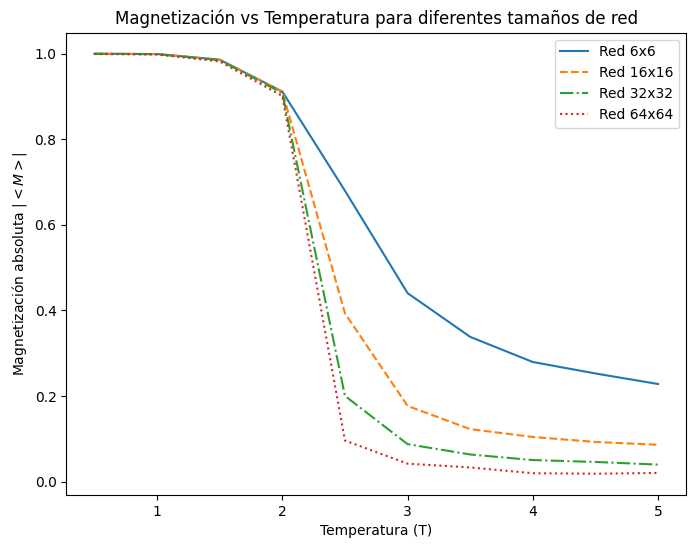

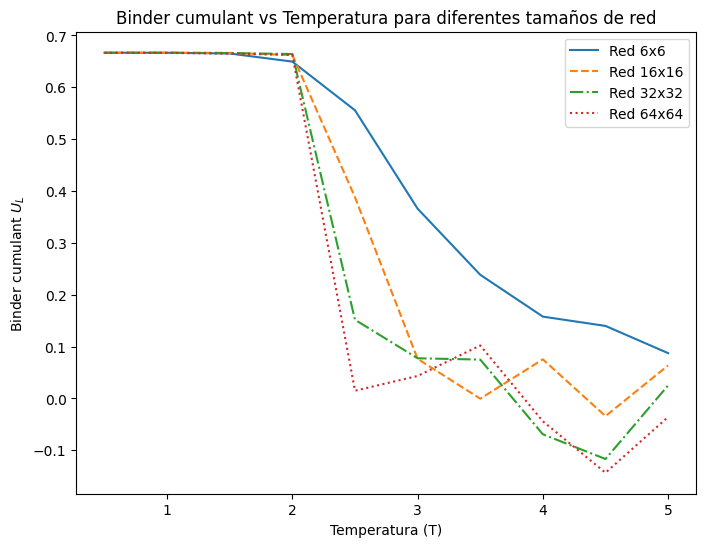

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Función para calcular el cumulante de Binder
def binder_cumulant(M2_av, M4_av):
    return 1 - (M4_av / (3 * M2_av**2))

# Función para simular y calcular la magnetización y Binder cumulant
def simulate_and_calculate(L, T_list, iter):
    N = L * L  # Total de espines
    vecinos = generar_vecinos(L)

    magnetizacion = []
    binder_values = []
    all_magnetization_samples = []  # Para almacenar todas las muestras de magnetización

    for T in T_list:
        beta = 1 / T
        p = 1 - np.exp(-2 * beta)

        # Inicializar configuración aleatoria de espines
        S = [random.choice([1, -1]) for _ in range(N)]

        # Inicializar acumuladores
        M_tot = 0
        M2_tot = 0
        M4_tot = 0

        for _ in range(iter):
            # Usar cluster flipping
            S = cluster_ising(S, N, p, vecinos)

            # Calcular la magnetización total
            M = np.sum(S)
            M_abs = abs(M)
            M_tot += M_abs
            M2_tot += M_abs**2
            M4_tot += M_abs**4
            all_magnetization_samples.append(M_abs)  # Agregar muestra al histograma total

        # Promedio de magnetización y Binder cumulant
        M_av = M_tot / iter
        M2_av = M2_tot / iter
        M4_av = M4_tot / iter
        binder = binder_cumulant(M2_av, M4_av)

        magnetizacion.append(M_av / N)  # Magnetización por espín
        binder_values.append(binder)

    return magnetizacion, binder_values, all_magnetization_samples

# Configuración del experimento
L_list = [6, 16, 32, 64]  # Tamaños de red
T_list = np.linspace(0.5, 5.0, 10)  # Rango de temperaturas
iter = 10000  # Número de iteraciones por temperatura

# Almacenar resultados de magnetización, Binder cumulant y muestras para histograma
magnetizacion_L = {}
binder_L = {}
all_magnetizations = {L: [] for L in L_list}

# Realizar simulaciones para cada tamaño de red
for L in L_list:
    magnetizacion, binder_values, all_magnetization_samples = simulate_and_calculate(L, T_list, iter)
    magnetizacion_L[L] = magnetizacion
    binder_L[L] = binder_values
    all_magnetizations[L] = all_magnetization_samples  # Guardar todas las muestras de magnetización

# Graficar histograma acumulado de magnetización para todas las redes
plt.figure(figsize=(10, 6))
for L in L_list:
    plt.hist(all_magnetizations[L], bins=50, alpha=0.6, label=f'Red {L}x{L}', density=True)
plt.xlabel('Magnetización |M|')
plt.ylabel('Frecuencia normalizada')
plt.title('Histograma acumulado de la magnetización para diferentes tamaños de red')
plt.legend()
plt.grid(True)
plt.show()

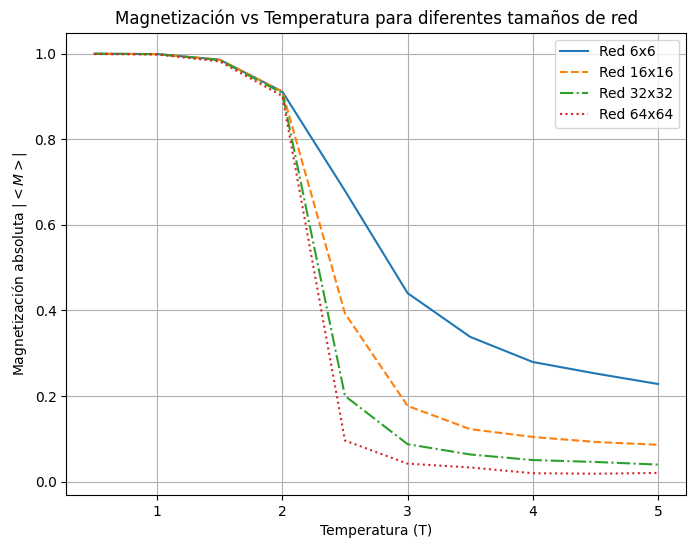

In [31]:
# Graficar magnetización vs temperatura para diferentes tamaños de red
plt.figure(figsize=(8, 6))
linestyles = {6: '-', 16: '--', 32: '-.', 64: ':'}
for L in L_list:
    plt.plot(T_list, magnetizacion_L[L], linestyle=linestyles[L], label=f'Red {L}x{L}')
plt.xlabel('Temperatura (T)')
plt.ylabel('Magnetización absoluta $|<M>|$')
plt.title('Magnetización vs Temperatura para diferentes tamaños de red')
plt.grid()
plt.legend()
plt.show()

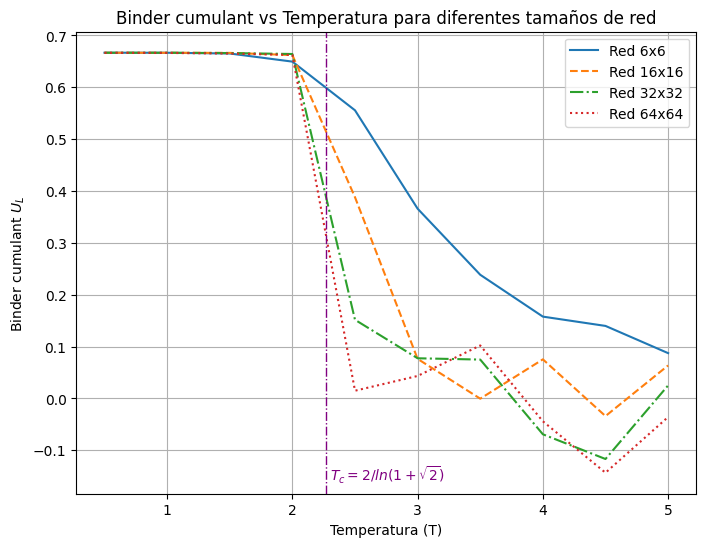

In [30]:
# Graficar Binder cumulant vs temperatura para diferentes tamaños de red
T_c = 2/(np.log(1+np.sqrt(2)))
plt.figure(figsize=(8, 6))
for L in L_list:
    plt.plot(T_list, binder_L[L], linestyle=linestyles[L], label=f'Red {L}x{L}')
plt.xlabel('Temperatura (T)')
plt.ylabel('Binder cumulant $U_L$')
plt.axvline(T_c, color = "purple", linewidth = 1, linestyle = "-.")
plt.grid()
plt.text(2.3, -0.16, '$T_c = 2/ln(1+ \sqrt{2})$', fontsize = 10, color = 'purple')
plt.title('Binder cumulant vs Temperatura para diferentes tamaños de red')
plt.legend()
plt.show()